In [21]:
# Code that reads in data files for question 2, copied from Homework 4

import numpy as np
import os

def parse_input_file(filename):
    num_topics = 0
    # Dirichlet hyperparams, aka alphas
    topic_priors = []
    # Beta prior for this document, words are rows, topic probabilities are columns.
    # This is the transpose of how Blei et al. do it.
    word_priors = []
    
    
    with open(filename, 'r') as f:
        lines = [line for line in f]
        num_topics = int(lines[0])
        assert(num_topics > 0)
        topic_priors = [float(tok.strip()) for tok in lines[1].split()]
        assert(len(topic_priors) == num_topics)
        for line in lines[2:]:
            tokens = line.split()
            word = tokens[0].strip()  # Not used
            word_probs = [float(tok.strip()) for tok in tokens[1:]]
            assert(len(word_probs) == num_topics)
            word_priors.append(word_probs)
    return num_topics, np.array(topic_priors), np.array(word_priors)


num_topics, topic_priors, word_priors = parse_input_file(
    'inference/hw6/ps4_data/abstract_nips21_NIPS2008_0517.txt.ready')

In [60]:
import scipy.special

# Variational EM, from Blei et al (2003), which estimates the value of theta.
def variational_em(num_topics, topic_priors, word_priors, num_iterations):
    num_words = len(word_priors)
    # The algo doesn't to actually use this.
    phi = np.full((num_words, num_topics), 1.0/num_topics)
    gammas = [np.array([topic_prior + float(num_words)/num_topics
                        for topic_prior in topic_priors])]
    for iteration in range(num_iterations-1):
        for word_index in range(num_words):
            prev_gamma = gammas[-1]
            phi_normalizer = 0.0
            for topic_index in range(num_topics):
                beta_val = word_priors[word_index][topic_index]
                gamma_val = prev_gamma[topic_index]
                psi = scipy.special.digamma(gamma_val)
                phi[word_index][topic_index] = beta_val * np.exp(psi)
                phi_normalizer += phi[word_index][topic_index]
            # normalize phi_ni
            for topic_index in range(num_topics):
                phi[word_index][topic_index] /= phi_normalizer
        new_gamma = np.add(topic_priors, np.sum(phi, axis=0))
        gammas.append(new_gamma)
    return gammas

In [61]:
vem_topic_dist_samples = variational_em(num_topics, topic_priors, word_priors, 
                                        1000)

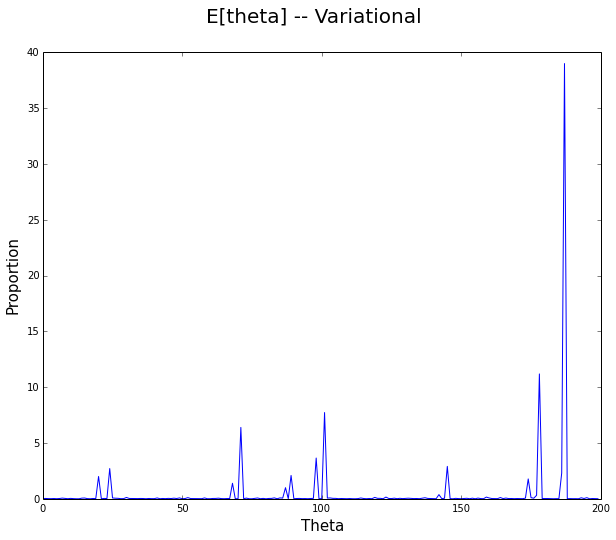

In [107]:
vem_topic_dist = vem_topic_dist_samples[-1]
fig = plt.figure(1, figsize=(10, 8))
fig.suptitle('E[theta] -- Variational', fontsize=20)
plt.xlabel('Theta', fontsize=15)
plt.ylabel('Proportion', fontsize=15)
plt.plot(range(len(vem_topic_dist)), vem_topic_dist)
plt.show()

In [49]:
# Uncollapsed Gibbs sampling code, taken from homework 4.

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from numpy.random import mtrand

# Sample a topic probability (theta) for the uncollapsed sampler.
def sample_topic_dist(topic_priors, topics):
    topic_counts = np.bincount(topics, minlength=len(topic_priors))
    posterior_topic_priors = [prior + count
                              for prior, count in zip(topic_priors, topic_counts)]
    return mtrand.dirichlet(posterior_topic_priors)


# Create the posterior probabilities for topics (z) for the uncollapsed sampler.
def sample_posterior_topic(word_index, word_priors, topic_dist):
    posterior_topic_probs = []
    denominator = 0.0
    word_prior_list = word_priors[word_index]
    for topic_index in range(len(topic_dist)):
        numerator = word_prior_list[topic_index] * topic_dist[topic_index] 
        posterior_topic_probs.append(numerator)
        denominator += numerator
    posterior_topic_probs = [prob/denominator for prob in posterior_topic_probs]
    topic_counts = mtrand.multinomial(1, posterior_topic_probs)
    for topic_index, sample_value in enumerate(topic_counts):
        if sample_value == 1:
            return topic_index
    raise Exception('Error occured while sampling topic')
    

# Returns an array of topic distribution samples
def uncollapsed_gibbs_sampler(num_topics, topic_priors, word_priors, 
                              num_iterations):
    # Initialize the topic_dist and topics to dummy values to start.
    initial_topic_dist = [1.0/num_topics]*num_topics
    initial_topics = [1]*len(word_priors)
    topic_dist_samples = [initial_topic_dist]
    topic_samples = [initial_topics]
    
    for iteration in range(num_iterations):
        prev_topics = topic_samples[-1]
        # Sample topic distribution (theta)
        topic_dist_sample = sample_topic_dist(topic_priors, prev_topics)
        # Initialize the topic sample to be the sample as the last one
        topics_sample = list(prev_topics)
        for i in range(len(topics_sample)):
            # Sample each topic instantiation (z_{mn})
            topics_sample[i] = sample_posterior_topic(i, word_priors, 
                                                      topic_dist_sample)    
        topic_dist_samples.append(topic_dist_sample)
        topic_samples.append(topics_sample)
    # Remove the 'burn' samples
    topic_dist_samples = topic_dist_samples[50:]
    return np.array(topic_dist_samples)


def uncollapsed_expected_topic_dist(samples):
    return np.mean(samples, axis=0)

In [50]:
# Uncollapsed topic distribution samples
u_topic_dist_samples = uncollapsed_gibbs_sampler(num_topics, topic_priors, word_priors,
                                                 1000)

In [51]:
# Collapsed Gibbs Sampling, taken from homework 4.

# Conditional probability of theta.
def sample_posterior_topic_collapsed(word_index, topic_sample, word_priors, 
                                     topic_priors):
    # Bucket topic samples, excluding the current topic sample
    topic_counts = [0]*len(topic_priors)
    for i, topic in enumerate(topic_sample):
        if i != word_index:
            topic_counts[topic] += 1
    # Compute each posterior topic probability
    posterior_topic_probs = []
    for topic_index in range(len(topic_priors)):
        word_prior = word_priors[word_index][topic_index]
        topic_prior = topic_priors[topic_index]
        topic_count = topic_counts[topic_index]
        prob = word_prior * (topic_prior + topic_count)
        posterior_topic_probs.append(prob)
    normalizer = sum(posterior_topic_probs)
    posterior_topic_probs = [prob/normalizer for prob in posterior_topic_probs]
    # Sample from the distribution
    sample = mtrand.multinomial(1, posterior_topic_probs)
    for topic_index, sample_value in enumerate(sample):
        if sample_value == 1:
            return topic_index
    raise Exception('Error occured while sampling topic')
    
    
# Returns an array of topic samples
def collapsed_gibbs_sampler(num_topics, topic_priors, word_priors, num_iterations):
    # Initialize the topics to dummy values to start.
    initial_topics = [1]*len(word_priors)
    topic_samples = [initial_topics]
    for iteration in range(num_iterations):
        topic_sample = list(topic_samples[-1])
        for i in range(len(topic_sample)):
            # Sample each topic instantiation (z_{mn})
            topic_sample[i] = sample_posterior_topic_collapsed(
                i, topic_sample, word_priors, topic_priors)
        topic_samples.append(topic_sample)
    # Remove the 'burn' samples
    topic_samples = topic_samples[50:]
    return np.array(topic_samples)


# Returns the expected value of the topic distribution (theta).
def collapsed_expected_topic_dist(topic_samples, topic_priors):
    T = len(topic_samples)
    topic_dist = np.zeros(len(topic_priors))
    for topic_sample in topic_samples:
        topic_dist += np.bincount(topic_sample, minlength=len(topic_priors))
    N = len(topic_samples[0])
    topic_dist += np.array([N*topic_prior for topic_prior in topic_priors])
    topic_dist /= T * (sum(topic_priors) + N)
    return topic_dist

In [52]:
# Collapsed topic distribution samples
c_topic_samples = collapsed_gibbs_sampler(num_topics, topic_priors, word_priors, 
                                          1000)

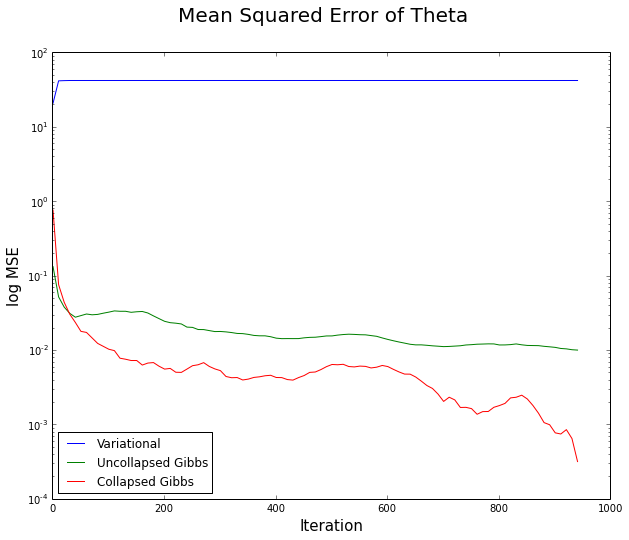

In [106]:
# Plotting L2 errors of variational EM, uncollapsed, and collasped Gibbs sampling.

import math
# u_samples are thetas and c_samples are z's.
def plot_error(vem_samples, u_samples, c_samples, topic_priors):
    assert len(u_samples) == len(c_samples), len(c_topic_samples)
    # Using collapsed sampler as ground truth
    gt_topic_dist = collapsed_expected_topic_dist(c_samples, topic_priors)
    xaxis = range(1, len(c_samples), 10)
    vem_errors = []
    u_errors = []
    c_errors = []
    for i in xaxis:
        tmp_vem_topic_dist = vem_samples[i]
        vem_error = math.sqrt(sum((gt_topic_dist - tmp_vem_topic_dist)**2))
        vem_errors.append(vem_error)
        tmp_u_topic_dist = uncollapsed_expected_topic_dist(u_samples[:i])
        u_error = math.sqrt(sum((gt_topic_dist - tmp_u_topic_dist)**2))
        u_errors.append(u_error)
        tmp_c_topic_dist = collapsed_expected_topic_dist(c_samples[:i], topic_priors)
        c_error = math.sqrt(sum((gt_topic_dist - tmp_c_topic_dist)**2))
        c_errors.append(c_error)
    fig = plt.figure(1, figsize=(10, 8))
    fig.suptitle('Mean Squared Error of Theta', fontsize=20)
    plt.xlabel('Iteration', fontsize=15)
    plt.ylabel('log MSE', fontsize=15)
    vem_line, = plt.plot(xaxis, vem_errors)    
    u_gibbs_line, = plt.plot(xaxis, u_errors)
    c_gibbs_line, = plt.plot(xaxis, c_errors)
    plt.legend([vem_line, u_gibbs_line, c_gibbs_line], 
               ['Variational', 'Uncollapsed Gibbs', 'Collapsed Gibbs'],
               loc='lower left')
    plt.yscale('log')
    plt.show()

plot_error(vem_topic_dist_samples, u_topic_dist_samples, c_topic_samples, 
           topic_priors)

## Part B: Analysis

The variational algorithm converges the fastest of the three. It converges only after a few iterations, while both versions of Gibbs sampling continue to have their error decline as the number of iterations increases. Additionally, the there is no randomness in the variational algorithm, so it converges to a precise value, with no fluctuations.

However, the variational algorithm's converged estimate for theta is only a lower bound to the true theta, so it has much higher error than either of the Gibbs methods. 